In [25]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pyhf
import matplotlib.pyplot as plt
from publik.pyhf_modifier import modifier
from publik.pyhf_modifier import plot

In [26]:
def null_dist(x, a=1., h1=2., h2=0.):
    return a*(1+x*h1-x**2*h2)

def alt_dist(x, a=1., h1=1., h2=1.):
    return a*(1-x*h1+x**2*h2)

In [27]:
# Set up the custom modifier
binning = np.array([2,3,4])
mapping_dist = np.array([[5.,0], [0,10.]])

new_params = {
                'a'   :{'inits': (2.,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'h'   :{'inits': (0.,0.), 'bounds': ((0., 5.),(1., 6.)), 'cov': [[1.,0.5],[0.5,1.]], 'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt_dist, null_dist, mapping_dist, binning)
cmod.expanded_pyhf

{'custom': (publik.pyhf_modifier.custom_modifier.add.<locals>._builder,
  publik.pyhf_modifier.custom_modifier.add.<locals>._applier),
 'histosys': (pyhf.modifiers.histosys.histosys_builder,
  pyhf.modifiers.histosys.histosys_combined),
 'lumi': (pyhf.modifiers.lumi.lumi_builder, pyhf.modifiers.lumi.lumi_combined),
 'normfactor': (pyhf.modifiers.normfactor.normfactor_builder,
  pyhf.modifiers.normfactor.normfactor_combined),
 'normsys': (pyhf.modifiers.normsys.normsys_builder,
  pyhf.modifiers.normsys.normsys_combined),
 'shapefactor': (pyhf.modifiers.shapefactor.shapefactor_builder,
  pyhf.modifiers.shapefactor.shapefactor_combined),
 'shapesys': (pyhf.modifiers.shapesys.shapesys_builder,
  pyhf.modifiers.shapesys.shapesys_combined),
 'staterror': (pyhf.modifiers.staterror.staterror_builder,
  pyhf.modifiers.staterror.staterror_combined)}

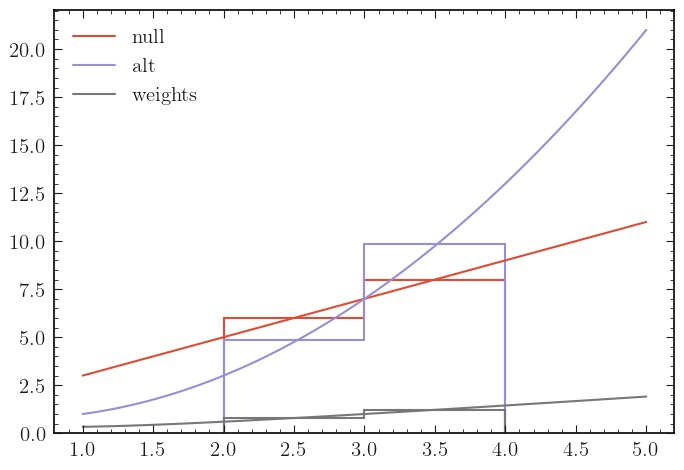

weights :  [0.80555556 1.22916667]


In [28]:
pars = [1,1]
lims = [1,5]
plot.dists(cmod, pars, lims, plot_weights=True)

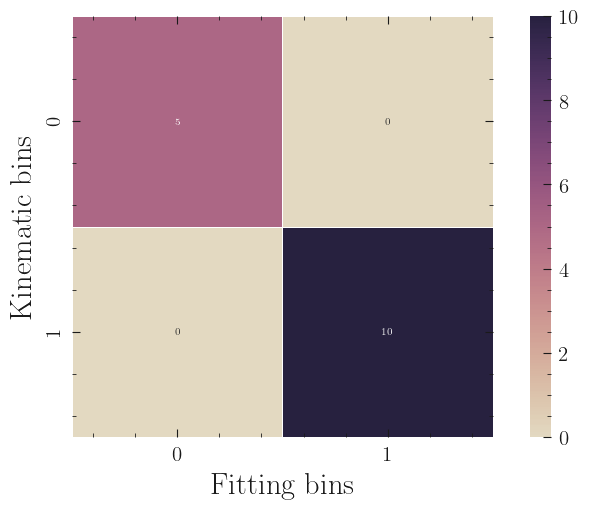

In [29]:
plot.map(cmod)

In [30]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [5.0, 10.0],
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            }
          ]
        },
        {
          "name": "background",
          "data": [50.0, 60.0],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [5.0, 12.0]
            }
          ]
        }
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [0, 1]
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
data = [58., 85.] + model.config.auxdata
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [5.0, 10.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function', 'ibin': [0, 1]}}]},
    {'name': 'background',
     'data': [50.0, 60.0],
     'modifiers': [{'name': 'uncorr_bkguncrt',
       'type': 'shapesys',
       'data': [5.0, 12.0]}]}]}]}

In [31]:
model.config.par_map

{'a': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x14c44127df40>},
 'h_decorrelated[0]': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14c44127dd60>},
 'h_decorrelated[1]': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14c44127d730>},
 'mu': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x14c44127d790>},
 'uncorr_bkguncrt': {'slice': slice(4, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x14c44127da90>}}

In [32]:
model.config.suggested_init()

[2.0, 0.0, 0.0, 1.0, 1.0, 1.0]

In [33]:
init = model.config.suggested_init()
init[0] = 2.
init[1] = -0.2
init[2] = -0.2

list(model.expected_actualdata(init))

[51.30103246039123, 62.36661220004794]

In [34]:
fixed = model.config.suggested_fixed()
fixed[0] = True
fixed[3] = True

best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict = cmod.rotate_pars(best_fit_dict)
best_fit_dict

{'a': 2.0,
 'h[0]': 0.1477629447599851,
 'h[1]': 0.6106487685344585,
 'mu': 1.0,
 'uncorr_bkguncrt': [1.0030595748032638, 1.0534196385793995]}

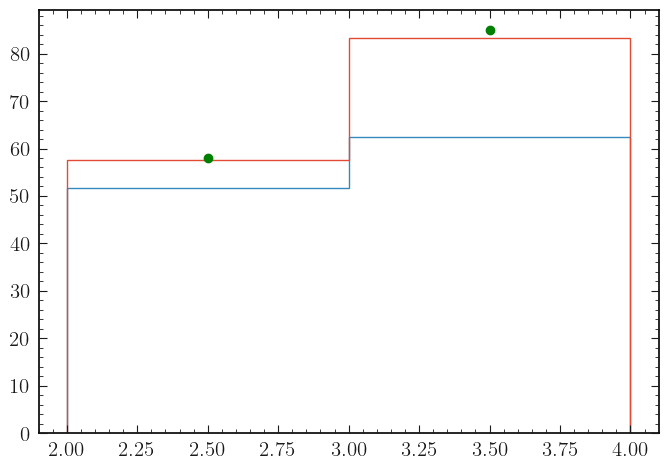

In [36]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), cmod.bins)
plt.stairs(model.expected_actualdata(best_fit), cmod.bins)
bin_cents = (cmod.bins[:-1] + cmod.bins[1:])/2
plt.plot(bin_cents, data[:2], 'og')